# Experiments to build AI conversational tools

### Uses cases:

* I/O definitions:
    * Input: 
        - Use case 1: requires name of "equipment" to identify "equipmetn group"
        - Use case 2: requines Yes/No answers to navigate on tree of questions
    * Output:
        - Use case 1: Output table with criteria columns 1 to 7 and 8a 
        - Use case 2: Output table with criteria columns 1 to 7, 8a and also 8b

* Use case 1: RAG compute probs of historical records:
    * System ask to SME for equipment to start analysis (system has some tolerance to admit synonims and misspeling)
    * System classify equipment in one of the known equipment group categories in DB, reporting to user equipment group
    * System reports to user stadistics for 1 to 8a question based on historical data of equipment group

* Use case 2: Question 8a and 8b
    * Use case 2 started after use case 1 is done.
    * If questions 8a is mojoritary "YES" for given equipment (more than 50% of historical records report YES) proceed with questionay, else end use cases with 8b field 'NO'
    * Doesn't matter the results from 1 o 7, if 8a question is yes we need to proceed with tree evaluation 
    * Questionary:
        - Ask follow-up questions in order, if user reply "NO"  end use cases with 8b field 'NO', if Answe is YES continue to next question. 
        - If usere reply "YES" to all question  end use cases with 8b field 'YES'

* Use case 3:
    * Run this uses case once uses Case 1 and Use case 2 are done.
    * Take from use case 1 answers 1 to 8a
    * Take from use case 2 answer 8b
    * Summarize all answer in one table and show final result with user


* UI requirements:
    * Chat window to get user inputs
    * Chat window to visualize LLM answers
    * Button to upload new files??  (optional)
    * Button to run offline task to pre compute equipment probs?? (optional)


In [1]:
import os
print(os.getcwd())
os.chdir("c:/Users/Jonathan_Espinosa/Projects/novartis/system_impact_classification")
print(os.getcwd())

c:\Users\Jonathan_Espinosa\Projects\novartis\system_impact_classification\playground
c:\Users\Jonathan_Espinosa\Projects\novartis\system_impact_classification


In [2]:
import os
from io import StringIO
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from operator import add
import pandas as pd
from dotenv import load_dotenv
from langchain.tools import  tool
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import END, START, StateGraph, MessagesState

In [3]:
from config import config
from custom_rag import get_equipment_scores

In [4]:
load_dotenv()
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") 
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME") 

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [5]:
# The structure of the logs
"""
class EntryGraphState(TypedDict):
    id: str
    counter: int = 0
    clinical_history: Optional[str]
    messages_human: Annotated[List[HumanMessage], add_messages]
    #messages_agent: Annotated[List[str], add]
    context: Optional[List[str]] # also Union[]
    id_trials_valid: Annotated[List[str], add]
    conversation_history: Annotated[List[SystemMessage|HumanMessage|AIMessage|ToolMessage], add_messages] # add_messages
    role_game_history: Annotated[List[HumanMessage|AIMessage], add_messages] 
"""

class AgentState(TypedDict):
    stage: int
    equipment: str
    human_message: str
    ai_message: str
    criteria_8a_status: bool
    criteria_8b_status: bool = False # Default doens't work need to update value in Node @todo check how to do 
    df_output: str # # pandas is not compatible "DataFrame is not serializable"
    current_question_id: int = 0



In [23]:

def df_string_encoder_decoder(df=None, df_str= None):
    # Step required to des-serialzie str DF. Cols should avoid whitespaces
    if df is None and isinstance(df_str, str):
        print('decoding str to pandas')
        df = pd.read_csv(StringIO(df_str), sep='\s+')
        df['equipment_group_name'] = df['equipment_group_name'].apply(lambda x: x.replace("_", " "))
        df.columns = [col.replace("_", " ") for col in df.columns]
        return df
    elif isinstance(df, pd.DataFrame) and df_str is None:
        print('encoding str to pandas')
        df.columns = [col.replace(" ", "_") for col in df.columns]
        df['equipment_group_name'] = df['equipment_group_name'].apply(lambda x: x.replace(" ", '_'))
        df_str = df.to_string(index=False)
        return df_str
    else:
        raise(TypeError, "provide a valid pandas data frame or string parsed version")
        

def node_get_human_equipment(state: AgentState):
    #@todo add regex for alphabetic - Camell case - Add Guardrails?? -
    print("---Step 1---")
    print('-----------Node get human equipment-------------------')
    equipment = state['equipment'].strip()
    stage = state['stage'] + 1
    equipment =  state['equipment']
    return {'equipment': equipment, 'stage': stage, 'current_question_id':0, 'criteria_8b_status':False }# Default 8B false and current_question_id=0 as not possinle to setup default value 

def node_rag(state:AgentState):
    print("---Step 2---")
    print('-----------Node RAG-------------------')
    user_equipment = state['equipment']
    stage = state['stage'] + 1
    print(f"RAG for input: {user_equipment}")
    df_equipment_score = get_equipment_scores(user_equipment=user_equipment)
    print("RAG Output:",df_equipment_score)
    value_8a = True if df_equipment_score['Criteria 8a'].values[0]>0.5 else False
    df_equipment_score_str = df_string_encoder_decoder(df=df_equipment_score)
    return {'df_output': df_equipment_score_str,  'criteria_8a_status': value_8a, 'stage': stage, } 

def question_8_eval(state:AgentState):
    print("---Step 3---")
    if state['criteria_8a_status']:
        return 'next_question'
    else:
        return 'generate_output'
    

def node_question_1(state: AgentState):
    print("---Step 4---")
    print('-----------Node question-------------------')
    current_question_id = state['current_question_id']
    quesions = ["1. The issue is related to IT protocol 00x1?", "The system reported log 00X2="]
    ai_message = quesions[current_question_id]
    #human_message_question_8b = state['human_message']
    #print(human_message_question_8b)
    print(f"Question {current_question_id}: {ai_message}")
    current_question_id = current_question_id+1
    return {'ai_message': ai_message, 'current_question_id':current_question_id}  

def node_human_feedback(state):
    print("---Step 5---")
    print("---node human_feedback---") # Need'criteria_8b_status': human_message_question_8b
    pass


def node_parse_output(state:AgentState):
    print("---Step 6---")
    df_output_str = state['df_output']
    df_output = df_string_encoder_decoder(df_str=df_output_str)
    df_output['Criteria 8a'] = [state['criteria_8a_status']]
    df_output['Criteria 8b'] =  [state['criteria_8b_status']]
    print('-----------Node output-------------------')
    df_output_str = df_string_encoder_decoder(df=df_output)
    print(df_output)
    return {'df_output': df_output_str}


In [7]:
"""
from io import StringIO
df = pd.read_csv('data_processed\equipment_group_probs.csv')
df_encoded = df_string_encoder_decoder(df=df, df_str=None)
print(type(df_encoded))
print(df_encoded)
df_decoded = df_string_encoder_decoder(df=None, df_str=df_encoded)
print(type(df_decoded))
print(df_decoded)
"""


"\nfrom io import StringIO\ndf = pd.read_csv('data_processed\\equipment_group_probs.csv')\ndf_encoded = df_string_encoder_decoder(df=df, df_str=None)\nprint(type(df_encoded))\nprint(df_encoded)\ndf_decoded = df_string_encoder_decoder(df=None, df_str=df_encoded)\nprint(type(df_decoded))\nprint(df_decoded)\n"

## 1. FLOW Version 1

In [24]:
# Node definitions
builder = StateGraph(AgentState)
builder.add_node("node_get_human_equipment", node_get_human_equipment)
builder.add_node("node_rag", node_rag)
builder.add_node("node_question_1", node_question_1)
builder.add_node("node_human_feedback", node_human_feedback)
builder.add_node("node_parse_output", node_parse_output)

# Node edges:
builder.add_edge(START, "node_get_human_equipment")
builder.add_edge("node_get_human_equipment", "node_rag")
builder.add_conditional_edges("node_rag", question_8_eval, {'next_question': "node_question_1",  "generate_output": 'node_parse_output'})
builder.add_edge("node_question_1", "node_human_feedback")
builder.add_edge("node_human_feedback", "node_parse_output")
builder.add_edge("node_parse_output", END)


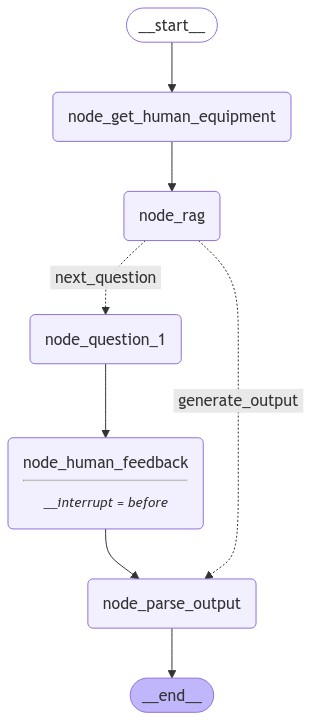

In [25]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# You MUST use a checkpoiner when using breakpoints. This is because your graph needs to be able to resume execution. (https://langchain-ai.github.io/langgraph/concepts/low_level/#configuration)
memory = MemorySaver()
#graph = builder.compile()
graph = builder.compile(checkpointer=memory, interrupt_before=["node_human_feedback"]) #   interrupt_before=['human_feedback'])


# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [30]:

config = {"configurable": {"thread_id": "1"}}
#graph.invoke({"stage":0, "equipment":"Freezer", 'human_message': False}, config)
# Cooling 8a-->1     Drying 8a->0
#result = graph.invoke({"stage":0, "equipment":"Coler", "current_question_id":0 }, config) 
#equipment = input("Hi I'm your AI asssistant. Please indicate the equipment to review")
initial_input = {"stage":0, "equipment":"Coler"}
for event in graph.stream(initial_input, config, stream_mode="values"):
    print(event)

{'stage': 0, 'equipment': 'Coler', 'ai_message': '1. The issue is related to IT protocol 00x1?', 'criteria_8a_status': True, 'criteria_8b_status': True, 'df_output': 'equipment_group_name  Criteria_1  Criteria_2  Criteria_3  Criteria_4  Criteria_5  Criteria_6  Criteria_7  Criteria_8a  Criteria_8b equipment_name\n             Cooling         1.0         0.0         1.0         0.0         1.0         0.0         1.0         True         True          Coler', 'current_question_id': 1}
---Step 1---
-----------Node get human equipment-------------------
{'stage': 1, 'equipment': 'Coler', 'ai_message': '1. The issue is related to IT protocol 00x1?', 'criteria_8a_status': True, 'criteria_8b_status': False, 'df_output': 'equipment_group_name  Criteria_1  Criteria_2  Criteria_3  Criteria_4  Criteria_5  Criteria_6  Criteria_7  Criteria_8a  Criteria_8b equipment_name\n             Cooling         1.0         0.0         1.0         0.0         1.0         0.0         1.0         True         Tru

In [31]:
graph.update_state(config, {"criteria_8b_status": False}, as_node="node_human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef97a57-35c5-6363-800b-771f28718d8e'}}

In [32]:
print(graph.get_state(config))
print(graph.get_state(config).next)

StateSnapshot(values={'stage': 2, 'equipment': 'Coler', 'ai_message': '1. The issue is related to IT protocol 00x1?', 'criteria_8a_status': True, 'criteria_8b_status': False, 'df_output': 'equipment_group_name  Criteria_1  Criteria_2  Criteria_3  Criteria_4  Criteria_5  Criteria_6  Criteria_7  Criteria_8a  Criteria_8b equipment_name\n             Cooling         1.0         0.0         1.0         0.0         1.0         0.0         1.0          1.0          0.0          Coler', 'current_question_id': 1}, next=('node_parse_output',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef97a57-35c5-6363-800b-771f28718d8e'}}, metadata={'source': 'update', 'step': 11, 'writes': {'node_human_feedback': {'criteria_8b_status': False}}, 'parents': {}}, created_at='2024-10-31T16:30:33.260323+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef97a56-e0d6-6463-800a-162949678426'}}, tasks=(PregelTask(id='5508d548-1797-

In [33]:
for event in graph.stream(None, config, stream_mode="values"):
    print(event)

{'stage': 2, 'equipment': 'Coler', 'ai_message': '1. The issue is related to IT protocol 00x1?', 'criteria_8a_status': True, 'criteria_8b_status': False, 'df_output': 'equipment_group_name  Criteria_1  Criteria_2  Criteria_3  Criteria_4  Criteria_5  Criteria_6  Criteria_7  Criteria_8a  Criteria_8b equipment_name\n             Cooling         1.0         0.0         1.0         0.0         1.0         0.0         1.0          1.0          0.0          Coler', 'current_question_id': 1}
---Step 6---
decoding str to pandas
-----------Node output-------------------
encoding str to pandas
  equipment_group_name  Criteria_1  Criteria_2  Criteria_3  Criteria_4  \
0              Cooling         1.0         0.0         1.0         0.0   

   Criteria_5  Criteria_6  Criteria_7  Criteria_8a  Criteria_8b equipment_name  
0         1.0         0.0         1.0         True        False          Coler  
{'stage': 2, 'equipment': 'Coler', 'ai_message': '1. The issue is related to IT protocol 00x1?', 'c